# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

Study on simple random sinusoidal images vs. real valued bent functions (maximaly non-linear) images

### Simple sinusoidal images:
Generate sinusoidal data with random phase and frequency:

$$Z = \sin(2\pi f_x x + \phi_x) \cos(2\pi f_y y + \phi_y)$$

Where:
- $f_x$ is the frequency multiplier for x
- $f_y$ is the frequency multiplier for y
- $\phi_x$ is the phase shift for x
- $\phi_y$ is the phase shift for y

### Real valued Bent functions:

$$Z = \cos(2\pi(aX + bY)) + \cos(2\pi(cX - dY))$$

Where $a$, $b$, $c$, and $d$ are parameters controlling the function's behavior.



## Imports and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchinfo
from IPython.display import display

In [3]:
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive

In [4]:
import polcanet.reports as report
import polcanet.utils as ut
from polcanet import PolcaNet

In [5]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

exp = ut.ExperimentInfoHandler(
    name="SYNTH_dataset",
    description="POLCA-Net on Synthetic Sinudosial and Bent Images",
    random_seed=random_seed,
)
ut.set_save_fig(False)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving Images: False, saving in path: /data1/deploy/polcanet/examples/notebooks/output/experiments/SYNTH_dataset


## Generate Synthetic Sinudosial and Bent Images

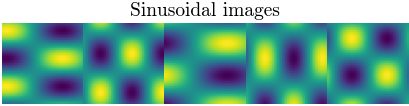

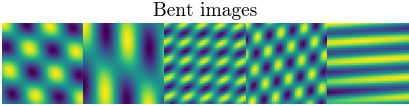

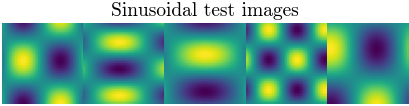

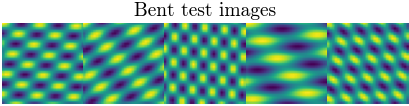

In [6]:
# Parameters 32x32 matrix for a single channel image
N = 32  # rows
M = 32  # cols


# Generate 2D sinusoidal data
data_sin = ut.generate_2d_sinusoidal_data(N, M, num_samples=2000)
data_sin_test = ut.generate_2d_sinusoidal_data(N, M, num_samples=500)

# Generate 2D real bent function images data
data_bent = ut.generate_bent_images(N, M, num_samples=2000)
data_bent_test = ut.generate_bent_images(N, M, num_samples=500)

ut.set_fig_prefix("sin_train")
ut.plot_train_images(data_sin, "Sinusoidal images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_train")
ut.plot_train_images(data_bent, "Bent images", cmap="viridis", n=5)

ut.set_fig_prefix("sin_test")
ut.plot_train_images(data_sin_test, "Sinusoidal test images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_test")
ut.plot_train_images(data_bent_test, "Bent test images", cmap="viridis", n=5)

### Perform PCA on datasets

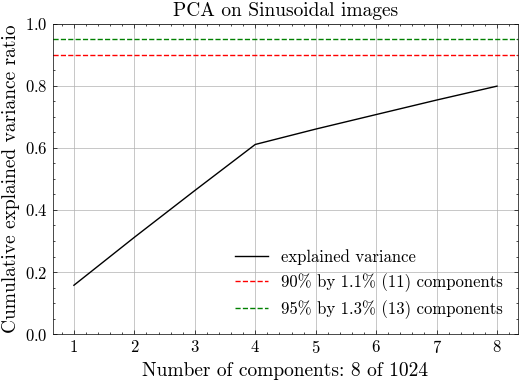

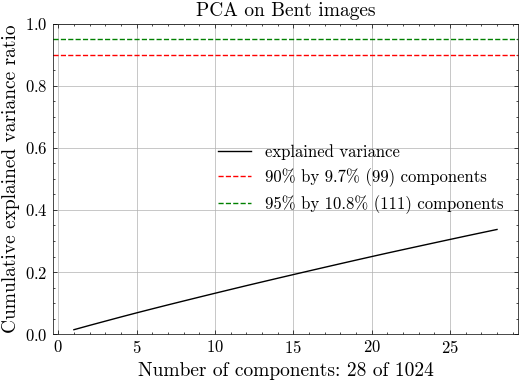

In [7]:
n_components = 8
ut.set_fig_prefix("sin")
pca_sin = ut.perform_pca(data_sin, title="PCA on Sinusoidal images", n_components=n_components)
Xpca_sin = pca_sin.transform(np.squeeze(data_sin.reshape(data_sin.shape[0], -1)))
plt.show()

n_components = 28
ut.set_fig_prefix("bent")
pca_bent = ut.perform_pca(data_bent, title="PCA on Bent images", n_components=n_components)
Xpca_bent = pca_bent.transform(np.squeeze(data_bent.reshape(data_bent.shape[0], -1)))
plt.show()

## POLCA-Net

### Train on Sinusoidal Images

In [8]:
import polcanet.aencoders as pae

ae_input = data_sin
act_fn = nn.SiLU
input_dim = (N, M)
latent_dim = pca_sin.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder_sin = pae.ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=6,
    act_fn=act_fn,
    size=N,
)

# decoder_sin = pae.LinearDecoder(
#     latent_dim=latent_dim,
#     input_dim=input_dim,
#     hidden_dim=12 * 256,
#     num_layers=3,
#     act_fn=nn.GELU,
#     bias=False,
# )

decoder_sin = pae.LinearConvDecoder(
    latent_dim=latent_dim,
    hidden_sizes=[256]*3,   
    output_dim=input_dim,
    initial_scale=4,
    act_fn=nn.GELU,
    bias = False,
)


model_sin = PolcaNet(
    encoder=encoder_sin,
    decoder=decoder_sin,
    latent_dim=latent_dim,
    r=1.0,
    c=0.0,
    alpha=(1e-1, 1),  # ortgogonality loss weigth, prob
    beta=(1e-1, 1),  # variance sorting loss weigth, prob
    gamma=(0, 1),  # variance reduction loss weigth, prob
    std_noise=0.0,  # no noise in this experiment
)

print(model_sin)

summary = torchinfo.summary(
    model_sin,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
    depth=1,
)
ut.save_text(str(model_sin), "model_sin.txt")
ut.save_text(str(summary), "model_sin_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (2): SiLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): SiLU()
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): SiLU()
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): SiLU()
        (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): SiLU()
        (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (12): SiLU()
        (13): Flatten(start_dim=1, end_dim=-1)
        (14): Linear(in_features=512, out_features=32, bias=True)
        (15): SiLU()
        (16): Linear(in_features=32, out_features=16, bias=True)
        (17)

In [9]:
model_sin.to("cuda")
model_sin.train_model(data=data_sin, val_data=data_sin_test, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 5000
Total Loss: 0.0003144
Reconstruction Loss: 0.0001013
Orthogonality Loss: 0.001573
Center of Mass Loss: 0.0005577

Final Validation metrics at epoch: 5000
Total Loss: 0.0003615
Reconstruction Loss: 0.0001371
Orthogonality Loss: 0.001703
Center of Mass Loss: 0.0005416


In [10]:
model_sin.train_model(data=data_sin, val_data=data_sin_test, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 5000
Total Loss: 0.0001098
Reconstruction Loss: 1.674e-05
Orthogonality Loss: 0.0007314
Center of Mass Loss: 0.000199

Final Validation metrics at epoch: 5000
Total Loss: 0.0002295
Reconstruction Loss: 4.163e-05
Orthogonality Loss: 0.00168
Center of Mass Loss: 0.0001987


In [11]:
model_sin.train_model(data=data_sin, val_data=data_sin_test, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 5000
Total Loss: 9.843e-05
Reconstruction Loss: 1.119e-05
Orthogonality Loss: 0.0006918
Center of Mass Loss: 0.0001807

Final Validation metrics at epoch: 5000
Total Loss: 0.0002253
Reconstruction Loss: 3.523e-05
Orthogonality Loss: 0.001723
Center of Mass Loss: 0.0001771


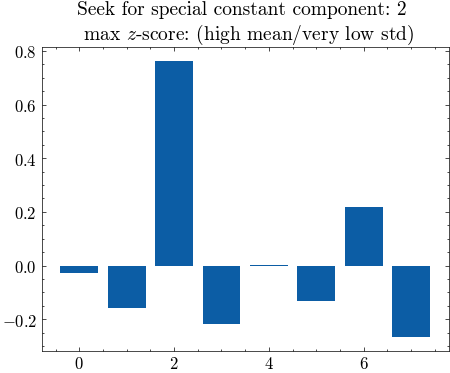

In [12]:
plt.figure()
z_score = model_sin.mu.cpu() / model_sin.std.cpu()
special_constant = np.argmax(z_score.abs())
plt.bar(range(latent_dim), z_score, label="std")
plt.title(f"Seek for special constant component: {special_constant} \n" + " max $z$-score: (high mean/very low std)")
plt.show()

In [13]:
ut.set_fig_prefix("sin_train")
report.loss_interaction_analysis(model_sin)

Loss Interaction Analysis Report:
Total interactions: 2228
Total conflicts: 586
Overall conflict rate: 0.2630

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,rec,com,2228,155,0.0696,0.0068,Weakly Cooperative
1,ort,com,2228,28,0.0126,0.1281,Strongly Cooperative
2,rec,ort,2228,403,0.1809,0.1812,Strongly Cooperative


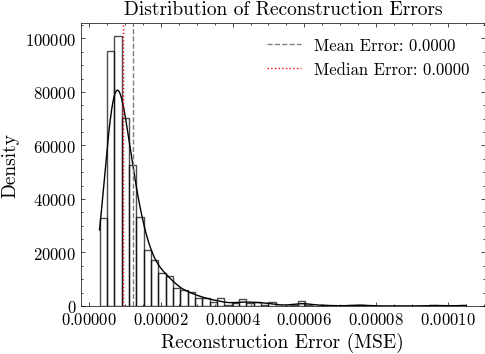

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0001


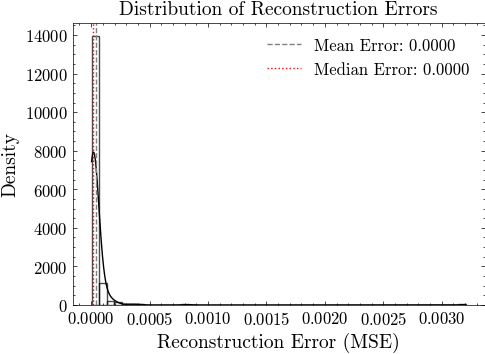

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0032


In [14]:
ut.set_fig_prefix("sin_train")
report.analyze_reconstruction_error(model_sin, data_sin, n_samples=1000)
ut.set_fig_prefix("sin_test")
report.analyze_reconstruction_error(model_sin, data_sin_test, n_samples=1000)

In [15]:
latents, reconstructed = model_sin.predict(data_sin)
data_sin.shape, reconstructed.shape, latents.shape

((2000, 32, 32), (2000, 32, 32), (2000, 8))

In [16]:
def plot_reconstruction(n_components):
    images = data_sin[0:16]
    ut.plot_reconstruction_comparison(
        model_sin, pca_sin, images, cmap="viridis", nrow=4, n_components=n_components, mask=[1, 1, 1, 1, 1, 1, 1, 1]
    )
    images = data_sin_test[0:16]
    ut.plot_reconstruction_comparison(
        model_sin, pca_sin, images, cmap="viridis", nrow=4, n_components=n_components, mask=[1, 1, 1, 1, 1, 1, 1, 1]
    )


interact(
    plot_reconstruction,
    n_components=widgets.IntSlider(min=1, max=pca_sin.n_components, step=1, value=pca_sin.n_components),
);

interactive(children=(IntSlider(value=8, description='n_components', max=8, min=1), Output()), _dom_classes=('…

In [17]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    print("TRAIN")
    ut.set_fig_prefix("sin_train")
    report.orthogonality_test_analysis(model_sin, pca_sin, data_sin)
with o2:
    print("TEST")
    ut.set_fig_prefix("sin_test")
    report.orthogonality_test_analysis(model_sin, pca_sin, data_sin_test)

layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
gridbox = widgets.GridBox(children=[o1, o2], layout=layout)
display(gridbox)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

In [18]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    print("TRAIN")
    ut.set_fig_prefix("sin_train")
    report.variance_test_analysis(model_sin, data_sin)
with o2:
    print("TEST")
    ut.set_fig_prefix("sin_test")
    report.variance_test_analysis(model_sin, data_sin_test)

layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
gridbox = widgets.GridBox(children=[o1, o2], layout=layout)
display(gridbox)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

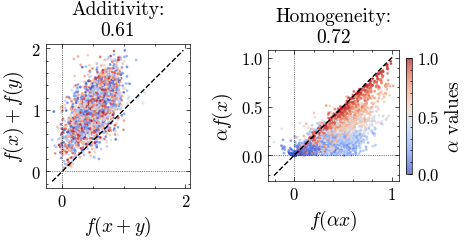

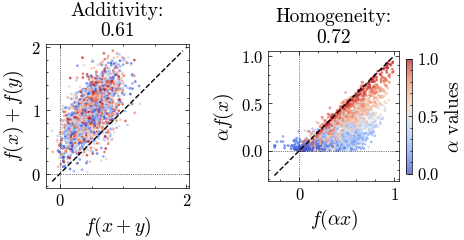

In [19]:
ut.set_fig_prefix("sin_train")
report.linearity_tests_analysis(model_sin, data_sin, alpha_min=0, num_samples=200)
ut.set_fig_prefix("sin_test")
report.linearity_tests_analysis(model_sin, data_sin_test, alpha_min=0, num_samples=200)

In [20]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = ut.plot2d_analysis(Xpca_sin, np.zeros(Xpca_sin.shape[0]), title="PCA transform", legend=False)
with o2:
    _, _ = ut.plot2d_analysis(latents, np.zeros(Xpca_sin.shape[0]), title="POLCA-Net latent", legend=False)
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

### Train on Bent Images

In [21]:
from polcanet.aencoders import ConvEncoder, LinearDecoder

ae_input = data_bent
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_bent.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder_bent = pae.ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=6,
    act_fn=act_fn,
    size=N,
)

decoder_bent = pae.LinearConvDecoder(
    latent_dim=latent_dim,
    hidden_sizes=[256]*3,   
    output_dim=input_dim,
    initial_scale=4,
    act_fn=nn.GELU,
    bias = False,
)


model_bent = PolcaNet(
    encoder=encoder_bent,
    decoder=decoder_bent,
    latent_dim=latent_dim,
    r=1.0,
    alpha=(1e-1, 1),  # ortgogonality loss weigth, prob
    beta=(1e-1, 1),  # variance sorting loss weigth, prob
    gamma=(0, 0),  # variance reduction loss weigth, prob
    std_noise=0.0,  # no noise in this experiment
)
print(model_bent)
summary = torchinfo.summary(
    model_bent,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["output_size", "num_params"],
    row_settings=["var_names"],
    depth=1,
)
ut.save_text(str(model_bent), "model_bent.txt")
ut.save_text(str(summary), "model_bent_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (2): SiLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): SiLU()
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): SiLU()
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): SiLU()
        (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): SiLU()
        (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (12): SiLU()
        (13): Flatten(start_dim=1, end_dim=-1)
        (14): Linear(in_features=512, out_features=112, bias=True)
        (15): SiLU()
        (16): Linear(in_features=112, out_features=56, bias=True)
        (1

In [22]:
model_bent.to("cuda")
model_bent.train_model(
    data=data_bent, val_data=data_bent_test, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3
)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 5000
Total Loss: 0.0003651
Reconstruction Loss: 0.0001151
Orthogonality Loss: 0.001547
Center of Mass Loss: 0.0009521

Final Validation metrics at epoch: 5000
Total Loss: 0.02564
Reconstruction Loss: 0.02496
Orthogonality Loss: 0.005992
Center of Mass Loss: 0.0007889


In [23]:
model_bent.train_model(
    data=data_bent, val_data=data_bent_test, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4
)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 5000
Total Loss: 0.0002123
Reconstruction Loss: 1.844e-05
Orthogonality Loss: 0.001483
Center of Mass Loss: 0.0004554

Final Validation metrics at epoch: 5000
Total Loss: 0.02633
Reconstruction Loss: 0.02557
Orthogonality Loss: 0.007225
Center of Mass Loss: 0.000352


In [24]:
model_bent.train_model(
    data=data_bent, val_data=data_bent_test, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5
)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Output()


Final Train metrics at epoch: 5000
Total Loss: 0.000206
Reconstruction Loss: 1.332e-05
Orthogonality Loss: 0.001502
Center of Mass Loss: 0.0004249

Final Validation metrics at epoch: 5000
Total Loss: 0.02645
Reconstruction Loss: 0.02567
Orthogonality Loss: 0.007514
Center of Mass Loss: 0.0003242


In [25]:
ut.set_fig_prefix("bent_train")
report.loss_interaction_analysis(model_bent)

Loss Interaction Analysis Report:
Total interactions: 2166
Total conflicts: 305
Overall conflict rate: 0.1408

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,rec,com,2166,136,0.0628,-0.0058,Weakly Conflicting
1,rec,ort,2166,167,0.0771,0.1715,Strongly Cooperative
2,ort,com,2166,2,0.0009,0.1839,Strongly Cooperative


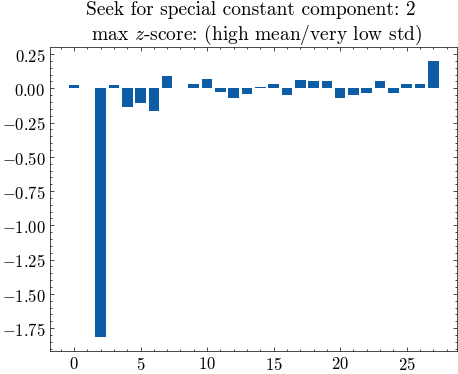

In [26]:
plt.figure()
z_score = model_bent.mu.cpu() / model_bent.std.cpu()
special_constant = np.argmax(z_score.abs())
plt.bar(range(latent_dim), z_score, label="std")
plt.title(f"Seek for special constant component: {special_constant} \n" + " max $z$-score: (high mean/very low std)")
plt.show()

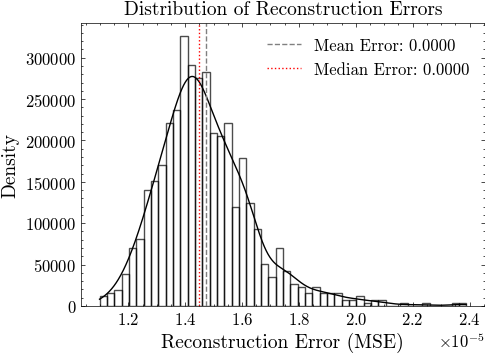

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0000


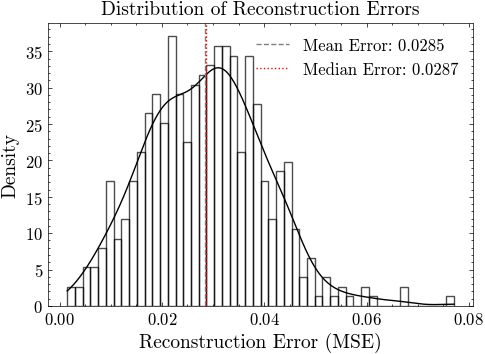

Mean Reconstruction Error: 0.0285
Median Reconstruction Error: 0.0287
Min Reconstruction Error: 0.0015
Max Reconstruction Error: 0.0771


In [27]:
ut.set_fig_prefix("bent_train")
report.analyze_reconstruction_error(model_bent, data_bent, n_samples=1000)
ut.set_fig_prefix("bent_test")
report.analyze_reconstruction_error(model_bent, data_bent_test, n_samples=1000)

In [28]:
latents, reconstructed = model_bent.predict(data_bent)
data_bent.shape, reconstructed.shape, latents.shape

((2000, 32, 32), (2000, 32, 32), (2000, 28))

In [29]:
def plot_reconstruction(n_components):
    images = data_bent[0:16]
    ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=4, n_components=n_components)
    images = data_bent_test[0:16]
    ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=4, n_components=n_components)


interact(
    plot_reconstruction,
    n_components=widgets.IntSlider(min=1, max=pca_bent.n_components, step=1, value=pca_bent.n_components),
);

interactive(children=(IntSlider(value=28, description='n_components', max=28, min=1), Output()), _dom_classes=…

,Metric,Value
0,Mean cosine similarity,0.017123
1,Median cosine similarity,0.014980
2,Standard deviation of cosine similarity,0.012777
3,Max cosine similarity,0.073598
4,Min cosine similarity,0.000012


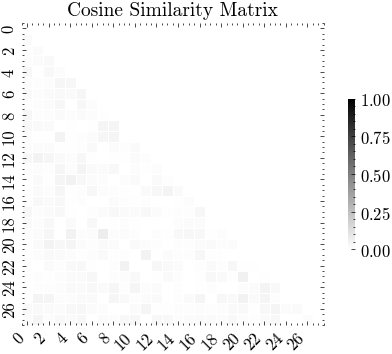

,Metric,Value
0,Mean mutual information,0.007869
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.018420
3,Max mutual information,0.224716
4,Min mutual information,0.000000


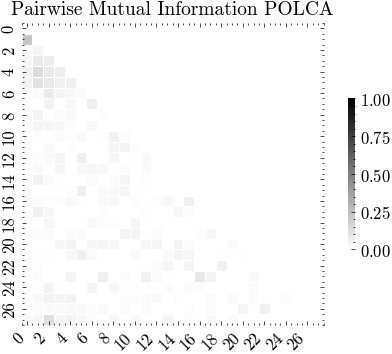

,Metric,Value
0,Mean mutual information,0.009499
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.018678
3,Max mutual information,0.191029
4,Min mutual information,0.000000


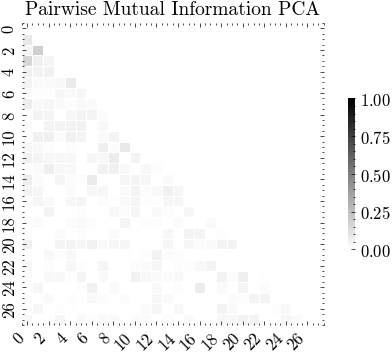

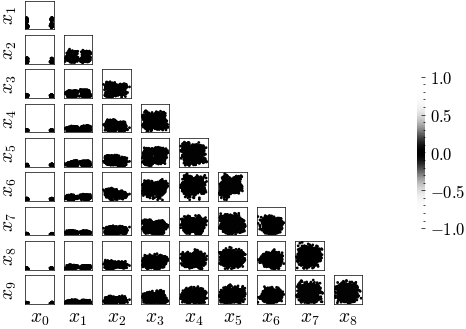

,Metric,Value
0,Mean cosine similarity,0.066412
1,Median cosine similarity,0.054217
2,Standard deviation of cosine similarity,0.055767
3,Max cosine similarity,0.347280
4,Min cosine similarity,0.000384


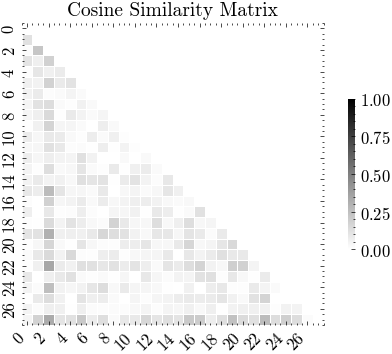

,Metric,Value
0,Mean mutual information,0.008864
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.019796
3,Max mutual information,0.178469
4,Min mutual information,0.000000


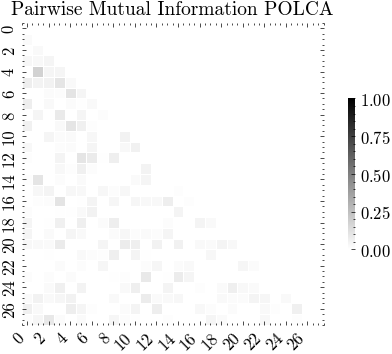

,Metric,Value
0,Mean mutual information,0.008891
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.018887
3,Max mutual information,0.113988
4,Min mutual information,0.000000


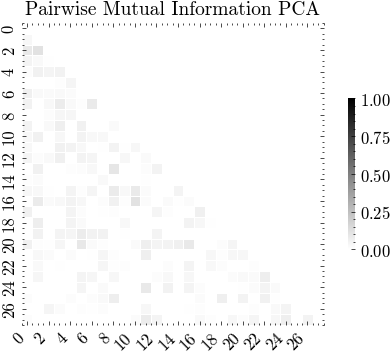

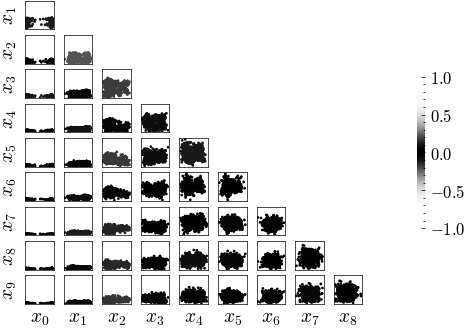

In [30]:
ut.set_fig_prefix("bent_train")
report.orthogonality_test_analysis(model_bent, pca_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.orthogonality_test_analysis(model_bent, pca_bent, data_bent_test)

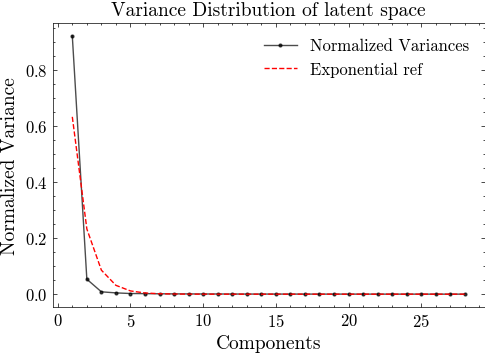

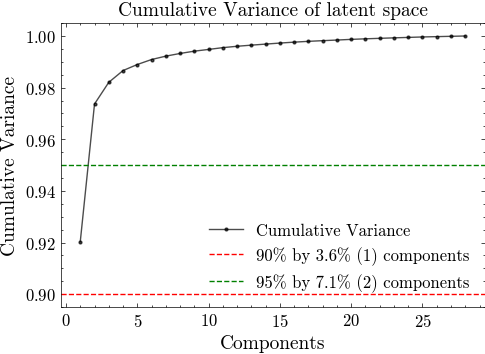

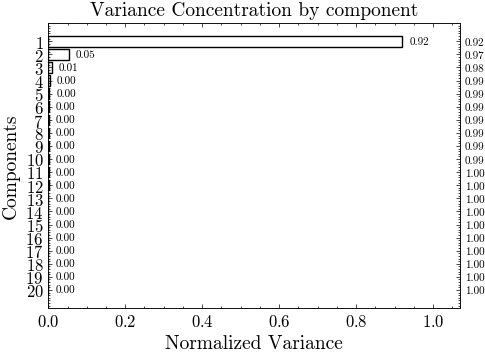

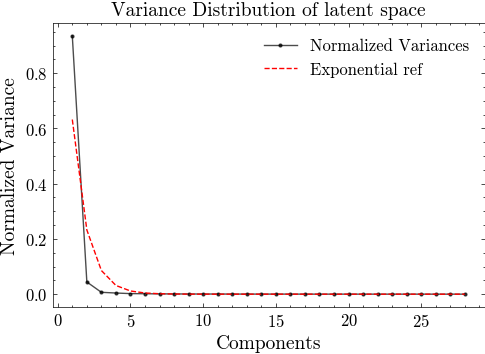

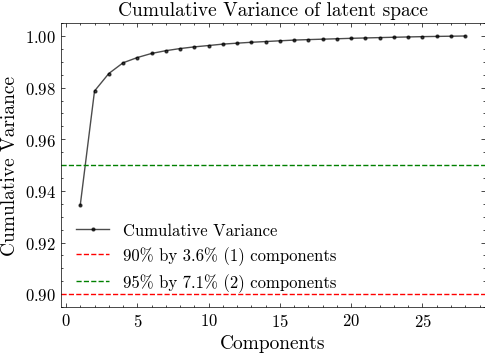

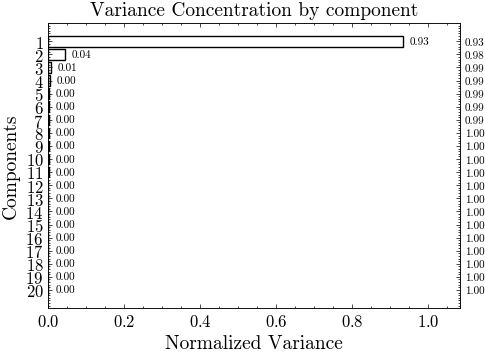

In [31]:
ut.set_fig_prefix("bent_train")
report.variance_test_analysis(model_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.variance_test_analysis(model_bent, data_bent_test)

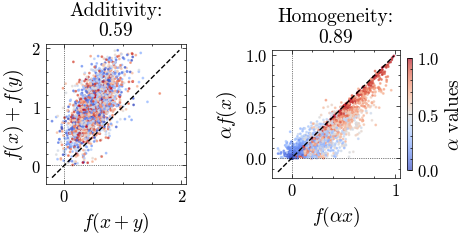

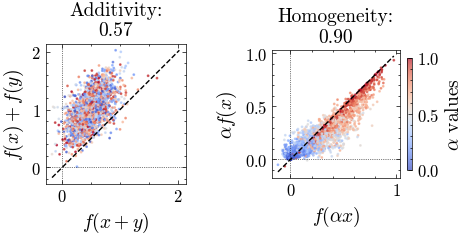

In [32]:
ut.set_fig_prefix("bent_train")
report.linearity_tests_analysis(model_bent, data_bent, alpha_min=0, num_samples=200)
ut.set_fig_prefix("bent_test")
report.linearity_tests_analysis(model_bent, data_bent_test, alpha_min=0, num_samples=200)

In [33]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = ut.plot2d_analysis(Xpca_bent, np.zeros(Xpca_bent.shape[0]), title="PCA transform", legend=False)
with o2:
    _, _ = ut.plot2d_analysis(latents, np.zeros(Xpca_bent.shape[0]), title="POLCA-Net latent", legend=False)
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

## Test Overall

In [34]:
experiment_data = {
    "Sinudoidal": (
        data_sin,
        model_sin,
        pca_sin,
    ),
    "Bent": (
        data_bent,
        model_bent,
        pca_bent,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,NMSE,PSNR,SSI
Method,,,
POLCA Sinudoidal,0.0060,49.9297,0.9998
PCA Sinudoidal,0.1838,20.7621,0.8404
POLCA Bent,0.0069,48.3389,0.9999
PCA Bent,0.3612,13.9567,0.5064
